<a href="https://colab.research.google.com/github/Hy-per-ion/ECG-Classification/blob/main/temporal_convolutional_%26_multihead%C2%A0attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

In [ ]:
class ECGImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.label_map = {
            'ECG Images of Myocardial Infarction Patients (240x12=2880)': 0,
            'ECG Images of Patient that have History of MI (172x12=2064)': 1,
            'ECG Images of Patient that have abnormal heartbeat (233x12=2796)': 2,
            'Normal Person ECG Images (284x12=3408)': 3
        }
        self._load_data()

    def _load_data(self):
        for folder in os.listdir(self.root_dir):
            folder_path = os.path.join(self.root_dir, folder)
            label = self.label_map[folder]
            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_name)
                self.image_paths.append(img_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (64, 64))

        if self.transform:
            img = self.transform(img)

        label = self.labels[idx]
        return img, label

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [ ]:
train_dataset = ECGImageDataset('/content/drive/MyDrive/ECG_Data/train', transform=transform)
test_dataset = ECGImageDataset('/content/drive/MyDrive/ECG_Data/test', transform=transform)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class TemporalConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TemporalConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=(1, 3), padding=(0, 1))
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        return F.relu(self.bn(self.conv(x)))

class TransformerSNNHybridModelWithTemporalConv(nn.Module):
    def __init__(self, num_classes=4, input_channels=1):
        super(TransformerSNNHybridModelWithTemporalConv, self).__init__()

        # Temporal Convolution Blocks
        self.tconv1 = TemporalConvBlock(input_channels, 32)
        self.tconv2 = TemporalConvBlock(32, 64)
        self.tconv3 = TemporalConvBlock(64, 128)

        # Self-Attention (Encoder)
        self.embedding_dim = 128
        self.self_attention = nn.MultiheadAttention(embed_dim=self.embedding_dim, num_heads=4, batch_first=True)

        # Fully Connected Layers
        self.flatten_size = 128 * 64 * 64
        self.fc1 = nn.Linear(self.flatten_size, 512)
        self.fc2 = nn.Linear(512, num_classes)


    def forward(self, x):
        # Apply Temporal Convolutions
        x = self.tconv1(x)
        x = self.tconv2(x)
        x = self.tconv3(x)

        # Flatten and Reshape for Self-Attention
        b, c, h, w = x.size()
        x = x.view(b, c, -1).permute(0, 2, 1)

        # Apply Self-Attention
        x, _ = self.self_attention(x, x, x)

        # Flatten for Fully Connected Layers
        x = x.contiguous().view(b, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
!pip install brian2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.1 MB/s eta 0:00:00


In [ ]:
from brian2 import *

def convert_to_spikes(image, spike_rate=20):
    image = image.numpy()
    image = np.clip(image.flatten(), 0, 1)
    spike_times = []

    # Encoding process
    for i, pixel in enumerate(image):
        spike_lambda = pixel * spike_rate
        if spike_lambda < 0:
            spike_lambda = 0

        # Poisson distribution to generate spikes
        spikes_for_pixel = np.random.poisson(spike_lambda, 1)
        spike_times.extend([i] * spikes_for_pixel)

    return spike_times

# SNN Layer
def snn_layer(input_spikes, num_neurons=100):
    start_scope()
    eqs = '''
    dv/dt = (I - v) / (10*ms) : 1
    I = 0 : 1 (constant)
    '''
    G = NeuronGroup(num_neurons, eqs, threshold='v>1', reset='v=0', method='exact')
    spikes = SpikeMonitor(G)

    for spike in input_spikes:
        G[spike].I = 1

    run(1 * second)
    return spikes.count

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    minutes = int(elapsed_time / 60)
    seconds = int(elapsed_time % 60)
    return minutes, seconds

def train(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        spike_inputs = [convert_to_spikes(image) for image in inputs]
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

def test(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            spike_inputs = [convert_to_spikes(image) for image in inputs]
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerSNNHybridModelWithTemporalConv(num_classes=4, input_channels=1).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

max_epochs = 50
stop_accuracy = 0.99

total_start_time = time.time()

for epoch in range(max_epochs):
    start_time = time.time()
    train_loss = train(model, train_loader, optimizer, criterion, device)
    accuracy = test(model, test_loader, device)
    end_time = time.time()
    epoch_minutes, epoch_seconds = epoch_time(start_time, end_time)
    print(f"Epoch [{epoch + 1}/{max_epochs}], Loss: {train_loss:.4f}, Accuracy: {accuracy:.4f}, Time: {epoch_minutes}m {epoch_seconds}s")

    if accuracy >= stop_accuracy:
        print(f"Training stopped as accuracy reached {accuracy * 100:.2f}% at epoch {epoch + 1}.")
        break

total_end_time = time.time()
total_minutes, total_seconds = epoch_time(total_start_time, total_end_time)

print(f"Training completed in {total_minutes}m {total_seconds}s.")

Epoch [1/50], Loss: 3.0139, Accuracy: 0.5246, Time: 64m 41s
Epoch [2/50], Loss: 1.1109, Accuracy: 0.5670, Time: 62m 43s
Epoch [3/50], Loss: 0.7432, Accuracy: 0.6540, Time: 58m 33s


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def evaluate_model(all_labels, all_preds):
    # Confusion Matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Myocardial Infarction', 'History of MI', 'Abnormal Heartbeat', 'Normal'],
                yticklabels=['Myocardial Infarction', 'History of MI', 'Abnormal Heartbeat', 'Normal'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification Report
    class_report = classification_report(all_labels, all_preds, target_names=['Myocardial Infarction', 'History of MI', 'Abnormal Heartbeat', 'Normal'])
    print("Classification Report:\n", class_report)

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        spike_inputs = [convert_to_spikes(image) for image in inputs]
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

evaluate_model(all_labels, all_preds)


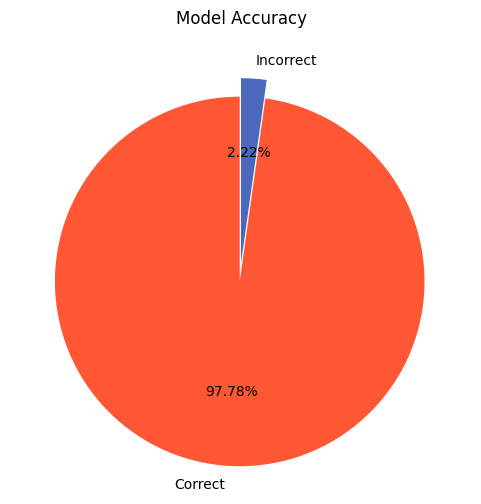

In [ ]:
import matplotlib.pyplot as plt

# Data
labels = ['Correct', 'Incorrect']
sizes = [97.78, 2.22]  # Percentages
colors = ['#ff5733', '#4a69bd']  # Bright Orange and Deep Maroon

explode = (0.1, 0)  # Highlight the 'Correct' segment

# Plotting the pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.2f%%', startangle=90, colors=colors, explode=explode)
plt.title('Model Accuracy')
plt.show()


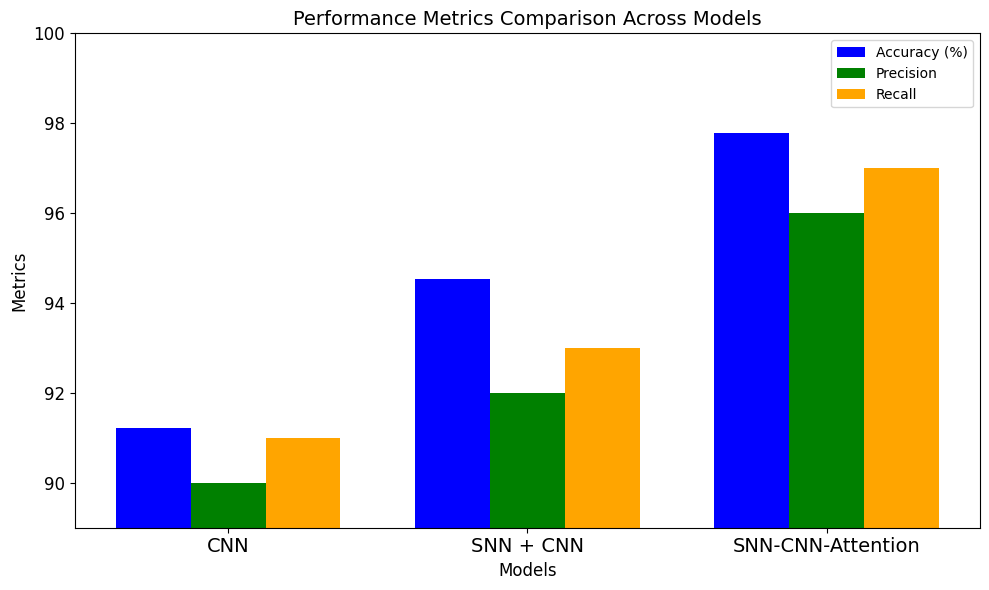

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the models
models = ['CNN', 'SNN + CNN', 'SNN-CNN-Attention']
accuracy = [91.21, 94.54, 97.78]
precision = [90, 92, 96]
recall = [91, 93, 97]

# Bar width
bar_width = 0.25

# Position of bars on the x-axis
x = np.arange(len(models))
x1 = x - bar_width
x2 = x
x3 = x + bar_width

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(x1, accuracy, color='blue', width=bar_width, label='Accuracy (%)')
plt.bar(x2, precision, color='green', width=bar_width, label='Precision')
plt.bar(x3, recall, color='orange', width=bar_width, label='Recall')

# Add labels, title, and legend
plt.xlabel('Models', fontsize=12)
plt.ylabel('Metrics', fontsize=12)
plt.title('Performance Metrics Comparison Between Models', fontsize=14)
plt.xticks(x, models, fontsize=14)  # Increased font size for model names
plt.yticks(fontsize=12)
plt.legend()

# Adjust y-axis range
plt.ylim(89, 100)

# Display the chart
plt.tight_layout()
plt.show()
